In [1]:
import pandas as pd
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import math
import warnings

In [3]:
warnings.filterwarnings("ignore",category=FutureWarning)


In [4]:
df=pd.read_csv("C:\\Users\\shsubham\\program\\DATA\\hackerearth\\planecrash\\train.csv")

In [5]:
le_Severity=LabelEncoder()
le_Severity.fit(df['Severity'])
df['Severity']=le_Severity.transform(df['Severity'])

In [75]:
le_Severity.classes_

array(['Highly_Fatal_And_Damaging', 'Minor_Damage_And_Injuries',
       'Significant_Damage_And_Fatalities',
       'Significant_Damage_And_Serious_Injuries'], dtype=object)

In [ ]:
#([0,1,2,3],['Highly_Fatal_And_Damaging','Minor_Damage_And_Injuries','Significant_Damage_And_Fatalities','Significant_Damage_And_Serious_Injuries'])

In [6]:
X=df.drop(["Severity"],axis=1)

In [7]:
y=df["Severity"]

In [8]:
X.drop(['Accident_ID','Accident_Type_Code'],axis=1,inplace=True)

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2)

In [17]:
X_train,X_holdout,X_test=np.split(X,[int(.7*len(X)),int(len(X)*.9)])

In [20]:
print(X_train.shape,X_test.shape,X_holdout.shape)

(7000, 9) (1000, 9) (2000, 9)


In [21]:
y_train,y_holdout,y_test=np.split(y,[int(.7*len(y)),int(len(y)*.9)])

In [54]:
def GridSearchGBM(X_train,y_train,lr=.3,trees=50,cv=10):
    default_learning_rate=.3
    default_num_of_tree=50
    base_GBM=GradientBoostingClassifier(learning_rate=lr,n_estimators=trees,max_depth=6,max_features='sqrt',min_samples_split=50,min_samples_leaf=10,subsample=1.0,n_iter_no_change=20,validation_fraction=.2)
    max_depth_val=[10,30,50,70,90,20]
    #max_depth_val=[10]
    min_samples_split_val=[4,8,16,32,64,128,256,512]
    #min_samples_split_val=[4]
    n_fe=len(X_train.columns)
    #max_features_val=[n_fe//2,n_fe//3,round(math.sqrt(n_fe)),n_fe]
    max_features_val=[n_fe]
    tol=1e-4
    first_tuning={'max_depth':max_depth_val,'min_samples_split':min_samples_split_val,'max_features':max_features_val}
    grid_model=GridSearchCV(estimator=base_GBM,param_grid=first_tuning,cv=cv)
    grid_model.fit(X_train,y_train)
    #learning-rate=2-10/num of trees
    learning_rate_val=[.2,.1,.05,.02,.01]
    #learning_rate_val=[.1]
    n_estimators_val=[50,100,200,400,500,800,1000]
    #n_estimators_val=[100,200]
    second_tuning={'learning_rate':learning_rate_val,'n_estimators':n_estimators_val}
    final_model=GridSearchCV(estimator=grid_model.best_estimator_,param_grid=second_tuning,cv=cv)
    final_model.fit(X_train,y_train)
    return final_model

In [29]:
def GridSearchXGBC(X_train,y_train,lr=.3,trees=50,cv=10):
    #XGB_classifier_param={'learning_rate':learning_rate_val,'subsample':subsample_val,'colsample_bytree':colsample_bytree_val}
    base_XGBC=XGBClassifier(objective='multi:softmax',booster='gbtree',n_estimators=trees,silent=0,learning_rate=lr,min_child_weight=1,max_depth=6,gamma=0,max_delta_setp=0,colsample_bytree=1)
    #max_depth_val=[100]
    max_depth_val=[10,30,50,70,90,20]
    #min_child_weight_val=[1]
    min_child_weight_val=[1,2,4,8] #equivalent of min_child_leaf in GBM
    #eta=learning_rate
    first_tuning={'max_depth':max_depth_val,'min_child_weight':min_child_weight_val}
    grid_model=GridSearchCV(estimator=base_XGBC,param_grid=first_tuning,cv=cv)
    grid_model.fit(X_train,y_train)
    #learning-rate=2-10/num of trees
    learning_rate_val=[.2,.1,.05,.02,.01]
    #learning_rate_val=[.2,.1]
    n_estimators_val=[50,100,200,400,500,800,1000]
    #n_estimators_val=[100,200]
    second_tuning={'learning_rate':learning_rate_val,'n_estimators':n_estimators_val}
    final_model=GridSearchCV(estimator=grid_model.best_estimator_,param_grid=second_tuning,cv=cv)
    final_model.fit(X_train,y_train)
    return final_model

In [25]:
def RandomSearchRandomForest(X_train,y_train,trees=50,cv=10):
    n_estimators_val = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features_val = ['auto', 'sqrt'] #[.2,.4,.6,.8]
    max_depth_val = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth_val.append(None)
    min_samples_split_val = [2, 5, 10]
    min_samples_leaf_val = [1, 2, 4]
    bootstrap_val = [True, False]
    random_grid={'n_estimators':n_estimators_val,'max_features':max_features_val,'max_depth':max_depth_val,
                 'min_samples_split':min_samples_split_val,
                 'min_samples_leaf':min_samples_leaf_val,
                 'bootstrap':bootstrap_val
                }
    base_model=RandomForestClassifier(random_state=108)
    random_model=RandomizedSearchCV(estimator=base_model,param_distributions=random_grid,n_iter=100,cv=cv,random_state=108,return_train_score=True)
    random_model.fit(X_train,y_train)
    return random_model

In [40]:
def ensemble_level_train(base_models,X_train,y_train):
    intermediate_input=pd.DataFrame()
    for model in base_models:
        model.fit(X_train,y_train)
        #y_temp=model.predict(X_holdout)
        #intermediate_input[model.__class__.__name__]=y_temp;
        #print(model.__class__.__name__,accuracy_score(y_holdout,y_temp))
    #return intermediate_input

In [43]:
def ensemble_level_predict(base_models,X_test):
    intermediate_input=pd.DataFrame()
    for model in base_models:
        y_temp=model.predict(X_test)
        intermediate_input[model.__class__.__name__]=y_temp;
    return intermediate_input

In [30]:
Grid_XGB=GridSearchXGBC(X_train,y_train,cv=3)

In [31]:
XGB_model=Grid_XGB.best_estimator_

In [33]:
XGB_model.feature_importances_

array([0.26336884, 0.22707438, 0.02505419, 0.18709669, 0.02801372,
       0.02201429, 0.03299121, 0.02347733, 0.1909094 ], dtype=float32)

In [34]:
X_train.columns

Index(['Safety_Score', 'Days_Since_Inspection', 'Total_Safety_Complaints',
       'Control_Metric', 'Turbulence_In_gforces', 'Cabin_Temperature',
       'Max_Elevation', 'Violations', 'Adverse_Weather_Metric'],
      dtype='object')

In [38]:
Grid_RandomForest=RandomSearchRandomForest(X_train,y_train,cv=3)

In [39]:
RandomForest_model=Grid_RandomForest.best_estimator_

In [42]:
base_models=[XGB_model,RandomForest_model]

In [44]:
y_holdout_pred=ensemble_level_predict(base_models,X_holdout)

In [55]:
Grid_stack_model=GridSearchGBM(y_holdout_pred,y_holdout,cv=3)

In [56]:
stack_model=Grid_stack_model.best_estimator_

In [57]:
intermediate_val=ensemble_level_predict(base_models,X_test)

In [58]:
final_pred=stack_model.predict(intermediate_val)

In [59]:
f1_score(y_test,final_pred,average='weighted')

0.9609879541672197

In [63]:
df_test=pd.read_csv("C:\\Users\\shsubham\\program\\DATA\\hackerearth\\planecrash\\test.csv")

In [64]:
df_accid=df_test['Accident_ID']

In [65]:
df_test.drop(['Accident_ID','Accident_Type_Code'],axis=1,inplace=True)

In [66]:
intermediate_test_input=ensemble_level_predict(base_models,df_test)

In [69]:
test_predict=stack_model.predict(intermediate_test_input)

In [68]:
test_final


array([0, 2, 3, ..., 3, 3, 0])

In [73]:
result=pd.DataFrame({'Accident_ID':df_accid,'Severity':test_predict})

In [74]:
result['Severity']=result['Severity'].replace([0,1,2,3],['Highly_Fatal_And_Damaging','Minor_Damage_And_Injuries','Significant_Damage_And_Fatalities','Significant_Damage_And_Serious_Injuries'])

In [72]:
result.to_csv("airplane_accident_prediction2901_2030.csv")

In [78]:
import tensorflow as tf


In [81]:
from tensorflow import keras

In [80]:
tf.__version__

'1.9.0'

In [83]:
keras.__version__

'2.1.6-tf'

In [85]:
model=keras.models.Sequential()

In [ ]:
#model.add.(keras.layers.Flatten())

In [135]:
#model.add(keras.layers.Flatten(9))
model.add(keras.layers.Dense(units=300,activation='relu',input_shape=X_train.shape[1:]))
#model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(4,activation='softmax'))

In [ ]:
activation='relu' is equivalent to activation= keras.activations.relu

In [89]:
model.layers

In [95]:
hidden1=model.layers[1].name

In [ ]:
hidden1.get_weights()

In [136]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='sgd',metrics=['accuracy'])
loss=keras.losses.sparse_categorical_crossentropy

In [121]:
#history=model.fit(X_train,y_train,epochs=30,validation_data=(X_holdout,y_holdout))

In [137]:
X_train_np=np.array(X_train)
y_train_np=np.array(y_train)
X_holdout_np=np.array(X_holdout)
y_holdout_np=np.array(y_holdout)
X_test_np=np.array(X_test)
y_test_np=np.array(y_test)

In [138]:
history=model.fit(X_train_np,y_train_np,epochs=30,validation_data=(X_holdout_np,y_holdout_np))

Train on 7000 samples, validate on 2000 samples
Epoch 1/30
7000/7000 [==============================] - 2s 330us/step - loss: 1.3748 - acc: 0.2927 - val_loss: 1.3681 - val_acc: 0.2965
Epoch 2/30
7000/7000 [==============================] - 1s 126us/step - loss: 1.3668 - acc: 0.3070 - val_loss: 1.3658 - val_acc: 0.2965
Epoch 3/30
7000/7000 [==============================] - 1s 108us/step - loss: 1.3658 - acc: 0.3070 - val_loss: 1.3655 - val_acc: 0.2965
Epoch 4/30
7000/7000 [==============================] - 1s 123us/step - loss: 1.3658 - acc: 0.3070 - val_loss: 1.3656 - val_acc: 0.2965
Epoch 5/30
7000/7000 [==============================] - 1s 102us/step - loss: 1.3656 - acc: 0.3070 - val_loss: 1.3658 - val_acc: 0.2965
Epoch 6/30
7000/7000 [==============================] - 1s 98us/step - loss: 1.3657 - acc: 0.3070 - val_loss: 1.3656 - val_acc: 0.2965
Epoch 7/30
7000/7000 [==============================] - 1s 103us/step - loss: 1.3657 - acc: 0.3070 - val_loss: 1.3655 - val_acc: 0.2965
E

In [115]:
type(y_train)

pandas.core.series.Series

In [107]:
X_np.head()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Max_Elevation,Violations,Adverse_Weather_Metric
0,49.223744,14,22,71.285324,0.272118,78.04,31335.476824,3,0.424352
1,62.465753,10,27,72.288058,0.423939,84.54,26024.711057,2,0.352350
2,63.059361,13,16,66.362808,0.322604,78.86,39269.053927,3,0.003364
3,48.082192,11,9,74.703737,0.337029,81.79,42771.499200,1,0.211728
4,26.484018,13,25,47.948952,0.541140,77.16,35509.228515,2,0.176883


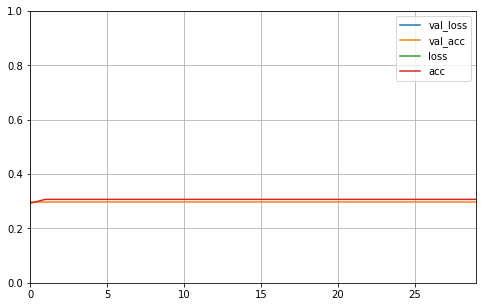

In [139]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [140]:
nn_predict=model.predict_classes(X_test_np)

In [131]:
X_train.shape[1:]

(9,)

In [141]:
f1_score(y_test_np,nn_predict,average='weighted')

0.1442218821729151